In [ ]:
!source /vol/cuda/11.2.1-cudnn8.1.0.77/setup.sh 

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import hashlib
from sklearn.preprocessing import StandardScaler

#add parent directory to path
work_dir = os.path.dirname(os.path.abspath(''))
print(work_dir)

sys.path.insert(0, os.path.join(
    os.path.dirname(work_dir), 'gplvm_causal_discovery'
))



# del sys.path[0]
#set manual color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['lightseagreen', 'salmon', 'slateblue', 'gold', 'mediumorchid', '#116b67', '#9a352d', '#3f3c6f', '#7b5a00', '#6d215e'])

In [ ]:
def plotPredictions(work_dir, dataset_name='', hpc=False):
    """
    Plot predictions of causal direction for each dataset
    """
    #set manual color cycle
    #plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['lightseagreen', 'salmon', 'slateblue', 'gold', 'mediumorchid', '#116b67', '#9a352d', '#3f3c6f', '#7b5a00', '#6d215e'])

    figpath = work_dir + '/figs/'
    results_path = work_dir + '/results/' + dataset_name + '/'

    #load predictions.csv
    if hpc:
        predictions = pd.read_csv(results_path + 'predictions_hpc.csv')
    else:
        predictions = pd.read_csv(results_path + 'predictions.csv')

    #get truth for each dataset
    datasets = predictions['dataset'].values.astype(int)
    targets = predictions['target'].values
    guesses = predictions['guess'].values

    #bar plot of each dataset on x axis, with loss predictions of direction on y axis as 1 and -1, coloured by truth
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))

    #plot correct guesses in green, incorrect in red
    if np.sum(guesses == targets) > 0:
        ax.bar(datasets[guesses == targets], guesses[guesses == targets], color='C0', label='correct')
    if np.sum(guesses != targets) > 0:
        ax.bar(datasets[guesses != targets], guesses[guesses != targets], color='C1', label='incorrect')

    #1 is causal, -1 is anti-causal on y axis
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(['anti-causal', 'causal'])
    ax.set_xlabel('dataset')
    ax.set_ylabel('prediction')
    ax.legend()
    plt.tight_layout()
    plt.savefig(figpath + dataset_name + '_causal_bar.jpg')
    plt.show()
    plt.close()



    #plot loss difference between causal and anti-causal for each dataset
    loss_diff = predictions['anti-causal_test_loss'].values - predictions['causal_test_loss'].values
    plt.figure(figsize=(15, 4))

    #correct guesses in green, incorrect in red
    if np.sum(guesses == targets) > 0:
        plt.stem(datasets[guesses == targets], loss_diff[guesses == targets], label='correct', markerfmt='C0o', linefmt='C0-', basefmt=' ')
    if np.sum(guesses != targets) > 0:
        plt.stem(datasets[guesses != targets], loss_diff[guesses != targets], label='incorrect', markerfmt='C1o', linefmt='C1-', basefmt=' ')
    #extend base line to cover entire x axis (sorted datasets)
    dsort = np.sort(datasets)
    plt.plot([dsort[0], dsort[-1]], [0, 0], 'k--', label='no difference')

    plt.xlabel('dataset')
    plt.ylabel('test loss difference (anti-causal - causal)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(figpath + dataset_name + '_causal_stem.jpg')
    plt.show()
    plt.close()

    print("loss prediction accuracy: {:.3f}".format(np.mean(guesses == targets)))


plotPredictions(work_dir, hpc=False, dataset_name='tueb')

      size  num_inducing  minibatch_size optimiser   method  target  \
349  16384            25              15   natgrad  general       1   
506  16384            25              15   natgrad  general       1   
412  16384            25              15   natgrad  general       1   
427  16384            25              15   natgrad  general       1   
599  16384            25              15   natgrad  general       1   

     causal_marginal_likelihood  causal_predictive_loss  \
349               -46821.936427            34540.718321   
506               -46821.936427            34540.718321   
412               -46909.075379            35123.966506   
427               -47120.497427            35359.892127   
599               -47232.899963            35221.771172   

     anti_marginal_likelihood  anti_predictive_loss  
349             -54215.774608          42415.885761  
506             -54215.774608          42415.885761  
412             -54434.919450          43637.412483  
42

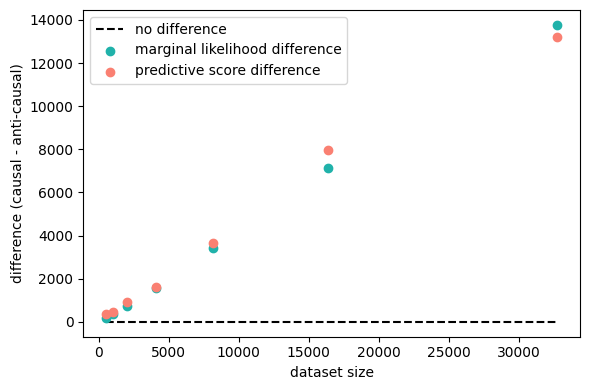

In [10]:
def plotInfResults(work_dir, log=False, norm=False):
    #import results/inf_data/results.csv
    results_path = work_dir + '/results/inf_data/'
    figpath = work_dir + '/figs/'
    results = pd.read_csv(results_path + 'results_general.csv')

    #print largest 5 causal and anti-causal likelihoods for size 512
    print(results.loc[results['size'] == 2**14].sort_values(by='causal_marginal_likelihood', ascending=False).head(5))
    print(results.loc[results['size'] == 2**14].sort_values(by='anti_marginal_likelihood', ascending=False).head(5))


    
    #choose row with lowest causal marginal likelihood for each dataset size
    min_causal = results.loc[results.groupby('size')['causal_marginal_likelihood'].idxmin()]
    min_causal = min_causal[['size', 'causal_marginal_likelihood', 'causal_predictive_loss']]

    max_causal = results.loc[results.groupby('size')['causal_marginal_likelihood'].idxmax()]
    max_causal = max_causal[['size', 'causal_marginal_likelihood', 'causal_predictive_loss']]

    #choose row with lowest anti-causal marginal likelihood for each dataset size
    min_anti = results.loc[results.groupby('size')['anti_marginal_likelihood'].idxmin()]
    min_anti = min_anti[['size', 'anti_marginal_likelihood', 'anti_predictive_loss']]

    max_anti = results.loc[results.groupby('size')['anti_marginal_likelihood'].idxmax()]
    max_anti = max_anti[['size', 'anti_marginal_likelihood', 'anti_predictive_loss']]

    #merge min_causal and min_anti on size
    min_marg_ll = pd.merge(min_causal, min_anti, on='size', how='inner')

    #merge max_causal and max_anti on size
    max_marg_ll = pd.merge(max_causal, max_anti, on='size', how='inner')

    results = max_marg_ll
    print(results)
    #plot causal - anti-causal marginal_likelihoods and predictive_losses for each dataset
    datasets = results['size'].values.astype(int)
    marg_ll_diff = results['causal_marginal_likelihood'].values - results['anti_marginal_likelihood'].values
    pred_loss_diff = results['causal_predictive_loss'].values - results['anti_predictive_loss'].values
    pred_score_diff = -1 * pred_loss_diff

    #divide by square of dataset size if normalising
    power = int(norm)
    marg_ll_diff = marg_ll_diff / (datasets ** power)
    pred_score_diff = pred_score_diff / (datasets ** power)

    #plot causal - anti-causal marginal_likelihoods and predictive_losses for each dataset on same plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    #infinite line at y=0 at back
    ax.hlines(0, datasets[0], datasets[-1], 'k', '--', label='no difference', zorder=0)
    
    
    ax.scatter(datasets, marg_ll_diff, label='marginal likelihood difference')
    if log:
        ax.set_yscale('log', base=2)
        ax.set_xscale('log', base=2)

    #ax.set_xticks(datasets)
    # ax.set_xlabel('dataset size')
    # ax.set_ylabel('difference (causal - anti-causal)')
    # ax.legend()
    # plt.tight_layout()
    # plt.show()
    # plt.close()


    #fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(datasets, pred_score_diff, label='predictive score difference')
    if log:
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
    #ax.set_xticks(datasets[::2])
    ax.set_xlabel('dataset size')
    ax.set_ylabel('difference (causal - anti-causal)')
    ax.legend()
    plt.tight_layout()
    plt.savefig(figpath + 'inf_data.pdf')
    plt.show()
    plt.close()

plotInfResults(work_dir, log=False, norm=False)

In [6]:
#show number of runs with each size
results_path = work_dir + '/results/inf_data/'
results = pd.read_csv(results_path + 'results_general.csv')
#number of runs with each size
print(results['size'].value_counts())

32768    93
4096     92
8192     88
2048     87
16384    87
1024     82
512      78
Name: size, dtype: int64


In [4]:
#show number of runs with each size
results_path = work_dir + '/results/inf_data/'
results = pd.read_csv(results_path + 'results_ind.csv')
#number of runs with each size
print(results['num_inducing'].value_counts())

25    607
Name: num_inducing, dtype: int64


   num_inducing  causal_marginal_likelihood  causal_predictive_loss  \
0            25                -2042.385860             1917.932502   
1            50                -2034.005639             1925.169168   
2           100                -2060.076826             1971.563439   
3           200                -2040.157928             1935.003690   
4           400                -2102.514700             1979.283087   
5           800                -2070.186531             1970.176781   
6          1000                -2183.139608             2051.299387   

   anti_marginal_likelihood  anti_predictive_loss  
0              -2453.239397           2551.572563  
1              -2415.737860           2798.940944  
2              -2395.701175           2578.838812  
3              -2480.060351           2528.604541  
4              -2458.510835           2477.137892  
5              -2498.934430           2432.874550  
6              -2531.413591           2493.318191  


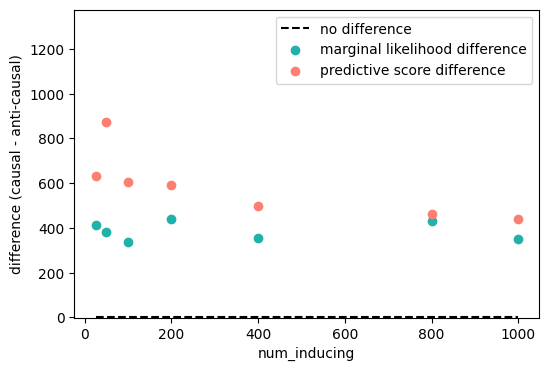

In [2]:
def plotNumIndResults(work_dir, log=False, norm=False):
    #import results/inf_data/results.csv
    results_path = work_dir + '/results/inf_data/'
    figpath = work_dir + '/figs/'    
    results = pd.read_csv(results_path + 'results_ind.csv')
    
    #choose row with lowest causal marginal likelihood for each dataset size
    min_causal = results.loc[results.groupby('num_inducing')['causal_marginal_likelihood'].idxmin()]
    min_causal = min_causal[['num_inducing', 'causal_marginal_likelihood', 'causal_predictive_loss']]

    max_causal = results.loc[results.groupby('num_inducing')['causal_marginal_likelihood'].idxmax()]
    max_causal = max_causal[['num_inducing', 'causal_marginal_likelihood', 'causal_predictive_loss']]

    #choose row with lowest anti-causal marginal likelihood for each dataset size
    min_anti = results.loc[results.groupby('num_inducing')['anti_marginal_likelihood'].idxmin()]
    min_anti = min_anti[['num_inducing', 'anti_marginal_likelihood', 'anti_predictive_loss']]

    max_anti = results.loc[results.groupby('num_inducing')['anti_marginal_likelihood'].idxmax()]
    max_anti = max_anti[['num_inducing', 'anti_marginal_likelihood', 'anti_predictive_loss']]

    #merge min_causal and min_anti on size
    min_marg_ll = pd.merge(min_causal, min_anti, on='num_inducing', how='inner')

    #merge max_causal and max_anti on size
    max_marg_ll = pd.merge(max_causal, max_anti, on='num_inducing', how='inner')

    results = max_marg_ll
    print(results)
    #plot causal - anti-causal marginal_likelihoods and predictive_losses for each dataset
    datasets = results['num_inducing'].values.astype(int)
    marg_ll_diff = results['causal_marginal_likelihood'].values - results['anti_marginal_likelihood'].values
    pred_loss_diff = results['causal_predictive_loss'].values - results['anti_predictive_loss'].values
    pred_score_diff = -1 * pred_loss_diff

    #divide by square of dataset size if normalising
    power = int(norm)
    marg_ll_diff = marg_ll_diff / (datasets ** power)
    pred_score_diff = pred_score_diff / (datasets ** power)

    #plot causal - anti-causal marginal_likelihoods and predictive_losses for each dataset on same plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    #infinite line at y=0 at back
    ax.hlines(0, datasets[0], datasets[-1], 'k', '--', label='no difference', zorder=0)
    
    
    ax.scatter(datasets, marg_ll_diff, label='marginal likelihood difference')
    if log:
        ax.set_yscale('log', base=2)
        ax.set_xscale('log', base=2)

    #fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(datasets, pred_score_diff, label='predictive score difference')
    if log:
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
    #ax.set_xticks(datasets[::2])
    ax.set_xlabel('num_inducing')
    ax.set_ylabel('difference (causal - anti-causal)')
    ax.set_ylim([-1, 1.5*ax.get_ylim()[1]])
    ax.legend()
    plt.savefig(figpath + 'num_ind.pdf')
    plt.show()
    plt.close()

plotNumIndResults(work_dir, log=False, norm=False)